# Updates

19/02 updates: Add Capsule Network

18/02 updates: Build .py file from this notebook for runing on the GPU console. And Try the task B as well. 

17/02 updates: Build text+img model. Mix text embedding and img data by concat them into one tensor. 3-class: 0.6, 5-class: 0.4459

16/02 updates: Add data augmentation. Also, use classes_weights to handle data imbanlance in training. 

15/02 updates: Uploaded the *data_7000_corrected.csv*, it fixes the data input error. Also uploaded the *data_7000_processed.csv*, it ignores 26 missing images (actual rows 6974) and contains img size attributes. 

***Please use the "data_7000_processed.csv" for the further analysis***

# Import Modules

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pandas as pd
import numpy as np
import os
from numpy import asarray
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, hamming_loss, zero_one_loss

%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Dense, Dropout, Activation, Flatten, Conv2D, BatchNormalization, Reshape, MaxPooling2D, CuDNNLSTM, Embedding, Concatenate
from tensorflow.keras.utils import plot_model

import keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks


TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
if __name__ == "__main__":
    print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1213132877135469537
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17796819615355856991
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3437789644369050850
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12402385908403249095
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


# Data Preparation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
cd /content/drive/My Drive/SemEval_2020

/content/drive/My Drive/SemEval_2020


## Read CSV Data

In [5]:
PATH_CSV = "./data_7000_processed.csv" # use pre-processed data, it ignores 26 missing images, actual enties are 6974
PATH_IMG = "./memotion_analysis_training_data/data_7000/"
trainX=[]
data = pd.read_csv(PATH_CSV, index_col=0)  
# data.columns = ['Image_name', 'Image_URL', 'OCR_extracted_text', 'corrected_text',
#        'Humour', 'Sarcasm', 'offensive', 'Motivational', 'Overall_Sentiment']
data.shape

(6974, 11)

In [6]:
data.head()

,Image_name,Image_URL,OCR_extracted_text,corrected_text,Humour,Sarcasm,offensive,Motivational,Overall_Sentiment,img_width,img_height
0,10_year_10-year-challenge_1547788782.jpeg,https://spiderimg.amarujala.com/assets/images/...,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive,749,506
1,10_year_10yearchallenge-5c75f8b946e0fb0001edc7...,https://www.lifewire.com/thmb/8wNfd94_meE9X2cp...,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive,766,571
2,10_year_10-year-challenge-sweet-dee-edition-40...,https://pics.conservativememes.com/10-year-cha...,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive,500,334
3,10_year_10-year-challenge-with-no-filter-47-hi...,https://pics.me.me/10-year-challenge-with-no-f...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral,500,429
4,10_year_10-years-challenge.jpg,https://i0.wp.com/beyondblindfold.com/wp-conte...,"What if the ""10 Year Challenge"" was created by...","What if the ""10 Year Challenge"" was created by...",hilarious,general,slight,not_motivational,very_positive,780,399


Show how many pictures in each class

In [7]:
data['Overall_Sentiment'].value_counts() #corrected data

positive         3117
neutral          2198
very_positive    1030
negative          479
very_negative     150
Name: Overall_Sentiment, dtype: int64

In [0]:
# # replace wrong data
# data.replace('positivechandler_Friday-Mood-AF.-meme-Friends-ChandlerBing.jpg', 'positive',inplace=True)
# #or delete wrong data
# # data = data[data['Overall_Sentiment'].isin(['positive','neutral','very_positive','negative','very_negative'])]
# data['Overall_Sentiment'].value_counts()

In [0]:
data.iloc[:,0:9].describe()

,Image_name,Image_URL,OCR_extracted_text,corrected_text,Humour,Sarcasm,offensive,Motivational,Overall_Sentiment
count,6974,6974,6814,6965,6974,6974,6974,6974,6974
unique,6973,6940,6620,6915,4,4,4,2,5
top,hillary_c3fd01300e5bee2ba12a45ee2f160ed11b8926...,"""https://images.complex.com/complex/image/uplo...","<html><head><meta content=""text/html; charset=...",#NAME?,funny,general,not_offensive,not_motivational,positive
freq,2,10,110,5,2449,3502,2704,4515,3117


In [0]:
data.describe()

,img_width,img_height
count,6974.000000,6974.000000
mean,587.009177,546.542587
std,256.502679,249.617494
min,100.000000,123.000000
25%,480.000000,392.000000
50%,500.000000,500.000000
75%,640.000000,648.750000
max,4961.000000,5553.000000


In [0]:
data['Sarcasm'].value_counts()

general            3502
twisted_meaning    1542
not_sarcastic      1538
very_twisted        392
Name: Sarcasm, dtype: int64

In [0]:
data['Motivational'].value_counts()

not_motivational    4515
motivational        2459
Name: Motivational, dtype: int64

In [0]:
data['offensive'].value_counts()

not_offensive        2704
slight               2587
very_offensive       1463
hateful_offensive     220
Name: offensive, dtype: int64

In [0]:
data['Humour'].value_counts()

funny         2449
very_funny    2231
not_funny     1646
hilarious      648
Name: Humour, dtype: int64

Random sampling for each class to create ***balanced*** data

In [0]:
minClassItem = data['Overall_Sentiment'].value_counts().min()
data_balanced = data.groupby('Overall_Sentiment',group_keys=False).apply(lambda x: x.sample(minClassItem, random_state=0))

data = data_balanced
data.shape

(750, 11)

In [0]:
data['Overall_Sentiment'].value_counts()

negative         150
very_positive    150
very_negative    150
positive         150
neutral          150
Name: Overall_Sentiment, dtype: int64

## Read Image data

In [0]:
# #use pillow, use the same data for missing channels in error image

# size = 73, 50
# X = [ ]     # creating an empty array
# error = []
# for img_name in tqdm(data['Image_name']):
#   if(os.path.isfile(PATH_IMG + img_name)):
#     image = Image.open(PATH_IMG + img_name)
#     img = asarray(image.resize(size))
#     if img.ndim != 3:
#       img = np.dstack([img, img, img])
#       error.append(img_name)
#     X.append(img)  # storing each image in array X
#   else:
#     error.append(img_name)
# X = np.array(X)    # converting list to array
# print(error)

In [0]:
## use cv2, and delete 2-channel error image
c = 0
size = 128,128  # img size: height, width 
X = [ ]     # creating an empty array
error = []
for img_name in tqdm(data['Image_name']):
  c += 1
#   image = Image.open(PATH_IMG + img_name)
#   img = asarray(image.resize(size))
  if(os.path.isfile(PATH_IMG + img_name)):
    image = cv2.imread((PATH_IMG + img_name), cv2.IMREAD_COLOR)
    if image is not None:
#       pass
      img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      #img = cv2.resize(img, size)
      if img.ndim != 3:                  # if the image is not RGB
        img = np.dstack([img, img, img]) # use the same value for the 3 RGB channels
      X.append(img)  # storing each image in array X
    else:
      print('None:{}'.format(img_name))
      error.append(img_name)
  else:
    print('Not Exists:{}'.format(img_name))
    error.append(img_name)
#   print(c,img.shape, img_name) # print each image infomaiton

print(error)
X = np.array(X)   # converting list to array

In [0]:
data = data[~data['Image_name'].isin(error)] # delete data of error images

Y = data['Overall_Sentiment']
num_class = 5
Y = to_categorical(Y.factorize()[0])

width, height, channels = X.shape[1:]

## *Or Import processed data*

In [0]:
# Import pre-processed image data
import pickle 

# pickle_out = open("/content/drive/My Drive/SemEval_2020/trainX_balanced.pickle", "wb")
# pickle.dump(X, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/SemEval_2020/trainY_balanced.pickle", "wb")
# pickle.dump(Y, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/SemEval_2020/data_balanced.pickle", "wb")
# pickle.dump(data, pickle_out)
# pickle_out.close()

data = pickle.load(open("/content/drive/My Drive/SemEval_2020/pickles/Corrected_7000/data_processed.pickle", "rb"))
error = pickle.load(open("/content/drive/My Drive/SemEval_2020/pickles/Corrected_7000/error_26img_name.pickle", "rb"))
X = pickle.load(open("/content/drive/My Drive/SemEval_2020/pickles/Corrected_7000/X_6974_128.pickle", "rb")) #import preprocessed 128*128 data
Y = pickle.load(open("/content/drive/My Drive/SemEval_2020/pickles/Corrected_7000/Y_6974.pickle", "rb"))
width, height, channels = X.shape[1:]
X = X/255

In [0]:
data.shape,len(error),X.shape,Y.shape

((6974, 11), 26, (6974, 128, 128, 3), (6974, 5))

In [0]:
Y_3 = data['Overall_Sentiment']
Y_3 = Y_3.replace('very_positive','positive').replace('very_negative','negative')
print(Y_3.value_counts())
num_class = 3
Y_3 = to_categorical(Y_3.factorize()[0])

# use classes weights to handle data imbalance
trainYcate3 = [np.argmax(i) for i in Y_3]
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(trainYcate3),
                                                 trainYcate3)
class_weights

positive    4147
neutral     2198
negative     629
Name: Overall_Sentiment, dtype: int64


array([0.56056587, 1.05762815, 3.69581346])

In [0]:
data.Overall_Sentiment.factorize()

(array([0, 1, 1, ..., 0, 2, 2]),
 Index(['very_positive', 'positive', 'neutral', 'negative', 'very_negative'], dtype='object'))

# Modelling

## Text Data
可以尝试conv1d

#### Model 0 - LSTM

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
t = Tokenizer()
X_text = data['corrected_text']
X_text = [str(i) for i in X_text]
t.fit_on_texts(X_text)
vocab_size = len(t.word_index) + 1
print (vocab_size)

13335


In [0]:
data['corrected_text']

0       The best of #10 YearChallenge! Completed in le...
1       Sam Thorne @Strippin ( Follow Follow Saw every...
2                  10 Year Challenge - Sweet Dee Edition 
3       10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...
4       What if the "10 Year Challenge" was created by...
                              ...                        
6995    That's a nice opinion you have there. Sure wou...
6996    YOU WON.ZUCKERBERG IS GIVING YOU THE MONEY! AN...
6997    USES TWITTER TO ASK THE INVENTOR OF FACEBOOK F...
6998    THE MORE OF YOUR DATA I GATHER THE MORE I UNDE...
6999    how can I delete Facebook without Mark Zuckerb...
Name: corrected_text, Length: 6974, dtype: object

In [0]:
encoded_train = t.texts_to_sequences(X_text)
max_length = max(list(map(lambda x: len(x), encoded_train)))
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')

padded_train[1]

array([3660, 5482, 5483,  214,  214,  501,  159,  794,  230, 1050,  445,
        548,  549,   39,  693,  754,  412, 1133,  297,  384, 1355,  548,
        282, 3661, 1051,  126, 5484,  305, 5485, 3661,  126, 3662,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

Split data into 80% training set and 20% test set using stratified sampling

In [0]:
# Train-test Split
np.random.RandomState(0)
trainX, testX, trainY, testY = train_test_split(padded_train, Y, test_size=0.2, random_state=0,stratify=Y)
# summarize dataset shape
print('Train', trainX.shape, trainY.shape)
print('Test', (testX.shape, testY.shape))

# summarize pixel values
print('Train', trainX.min(), trainX.max(), trainX.mean(), trainX.std())
print('Test', testX.min(), testX.max(), testX.mean(), testX.std())

Train (5579, 192) (5579, 5)
Test ((1395, 192), (1395, 5))
Train 0 13334 99.03451279351138 808.8886122835717
Test 0 13329 97.51824596774193 794.9804148494134


In [0]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Dropout(0.1))


model.add(CuDNNLSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(32, activation='relu'))

model.add(Dense(5, activation='softmax'))

# opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
model.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 192, 100)          1333500   
_________________________________________________________________
dropout (Dropout)            (None, 192, 100)          0         
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 192, 128)          117760    
_________________________________________________________________
dropout_1 (Dropout)          (None, 192, 128)          0         
_________________________________________________________________
flatten (Flatten)            (None, 24576)             0         
_____________________________________________________

In [0]:
results = model.fit(trainX, trainY, epochs=10, shuffle=True, validation_data=(testX,testY), batch_size=64)

Train on 5579 samples, validate on 1395 samples
Epoch 1/10
5579/5579 [==============================] - 9s 2ms/sample - loss: 1.2992 - acc: 0.4370 - val_loss: 1.2819 - val_acc: 0.4466
Epoch 2/10
5579/5579 [==============================] - 1s 258us/sample - loss: 1.2525 - acc: 0.4694 - val_loss: 1.3263 - val_acc: 0.4294
Epoch 3/10
5579/5579 [==============================] - 1s 258us/sample - loss: 1.0221 - acc: 0.6055 - val_loss: 1.4885 - val_acc: 0.4029
Epoch 4/10
5579/5579 [==============================] - 1s 258us/sample - loss: 0.7239 - acc: 0.7175 - val_loss: 1.8399 - val_acc: 0.3692
Epoch 5/10
5579/5579 [==============================] - 1s 258us/sample - loss: 0.4827 - acc: 0.8351 - val_loss: 2.2891 - val_acc: 0.3498
Epoch 6/10
5579/5579 [==============================] - 1s 256us/sample - loss: 0.3223 - acc: 0.8944 - val_loss: 2.4361 - val_acc: 0.3584
Epoch 7/10
5579/5579 [==============================] - 1s 256us/sample - loss: 0.2277 - acc: 0.9244 - val_loss: 3.0354 - val_

In [0]:
model.evaluate(testX,testY)

1395/1395 [==============================] - 4s 3ms/sample - loss: 6.9621 - acc: 0.3412


[6.962111677832929, 0.34121865]

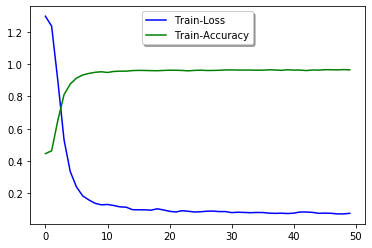

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)

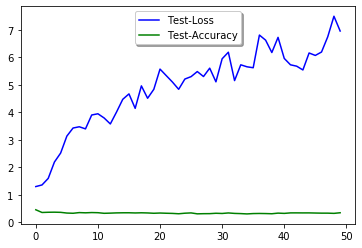

In [0]:
plt.plot(list(results.history.values())[2],'b',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

## Image Data

In [0]:
# Train-test Split
np.random.RandomState(0)

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=0,stratify=Y)

# summarize dataset shape
print('Train', trainX.shape, trainY.shape)
print('Test', (testX.shape, testY.shape))

# summarize pixel values
print('Train', trainX.min(), trainX.max(), trainX.mean(), trainX.std())
print('Test', testX.min(), testX.max(), testX.mean(), testX.std())

Train (5579, 128, 128, 3) (5579, 5)
Test ((1395, 128, 128, 3), (1395, 5))
Train 0.0 1.0 0.48095478055148694 0.35130917307437204
Test 0.0 1.0 0.4842861692331303 0.352107603382119


In [0]:
# use classes weights to handle data imbalance
trainYcate = [np.argmax(i) for i in trainY]
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(trainYcate),
                                                 trainYcate)
class_weights

array([1.35412621, 0.44739374, 0.63469852, 2.91331593, 9.29833333])

In [0]:
# reshape dataset to have a single channel
# width, height, channels = trainX.shape[1], trainX.shape[2], trainX.shape[3]
# trainX = trainX.reshape((trainX.shape[0], width,height,channels))
# testX = testX.reshape((testX.shape[0], width,height,channels))

# one hot encode target values
# trainY = to_categorical(trainY.factorize()[0])
# testY = to_categorical(testY.factorize()[0])

# create generator (1.0/255.0 = 0.003921568627451)
# datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True) # standardize
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False
)
datagen.fit(trainX)


# # prepare an iterators to scale images
# train_iterator = datagen.flow(trainX, trainY, batch_size=64)
# test_iterator = datagen.flow(testX, testY, batch_size=64)
# print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))

# # confirm the scaling works
# batchX, batchy = train_iterator.next()
# print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

### Model 1 - CIFAR10 CNN 0.38
Conv-Conv-Maxpool-Dense
https://keras.io/examples/cifar10_cnn/

In [0]:
# define model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(width, height, channels)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.20))

model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.2))


model.add(Dense(5, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 63, 63, 32)        9248      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 32)       

In [0]:
es = callbacks.EarlyStopping(monitor='val_acc', mode='max')

# fit model with generator
results = model.fit(trainX, trainY,
         epochs=10,
         batch_size=64,
         shuffle=True,
#         validation_split=0.2
         validation_data=(testX,testY),
#          callbacks=[es],
         class_weight=class_weights          
         )
# model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator), epochs=1)

# evaluate model
# _, acc = model.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=0)
# print('Test Accuracy: %.3f' % (acc * 100))

Train on 5579 samples, validate on 1395 samples
Epoch 1/10
5579/5579 [==============================] - 9s 2ms/sample - loss: 1.3045 - acc: 0.4400 - val_loss: 1.2921 - val_acc: 0.4466
Epoch 2/10
5579/5579 [==============================] - 9s 2ms/sample - loss: 1.2815 - acc: 0.4402 - val_loss: 1.2895 - val_acc: 0.4466
Epoch 3/10
5579/5579 [==============================] - 9s 2ms/sample - loss: 1.2800 - acc: 0.4454 - val_loss: 1.2750 - val_acc: 0.4466
Epoch 4/10
5579/5579 [==============================] - 9s 2ms/sample - loss: 1.2702 - acc: 0.4476 - val_loss: 1.2796 - val_acc: 0.4337
Epoch 5/10
5579/5579 [==============================] - 9s 2ms/sample - loss: 1.2500 - acc: 0.4637 - val_loss: 1.3324 - val_acc: 0.4437
Epoch 6/10
5579/5579 [==============================] - 9s 2ms/sample - loss: 1.1970 - acc: 0.4854 - val_loss: 1.3794 - val_acc: 0.3699
Epoch 7/10
5579/5579 [==============================] - 9s 2ms/sample - loss: 1.0647 - acc: 0.5530 - val_loss: 1.4994 - val_acc: 0.4093


In [0]:
results = model.fit_generator(datagen.flow(trainX, trainY, batch_size=64),
                    steps_per_epoch=len(trainX) / 64, epochs=10,class_weight=class_weights, validation_data=(testX,testY))

In [0]:
model.evaluate(testX,testY)

1395/1395 [==============================] - 1s 854us/sample - loss: 2.7788 - acc: 0.3814


[2.778820258998529, 0.38136202]

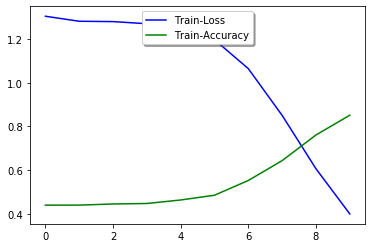

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)

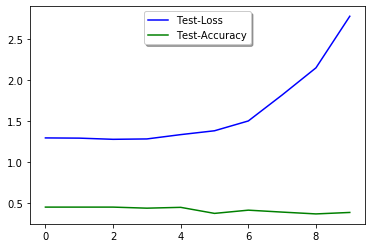

In [0]:
plt.plot(list(results.history.values())[2],'b',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

### Model 2 (Siyuan) 0.446
Conv32-Conv64-Conv128-Dense128 (image only)

In [0]:
# 3 Conv model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 32768)           

In [0]:
es = callbacks.EarlyStopping(monitor='loss', mode='min')
results = model.fit(trainX, trainY,
         epochs=30,
         batch_size=64,
         shuffle=True,
#         validation_split=0.5
         validation_data=(testX,testY),
#          callbacks=[es],
        class_weight=class_weights,
         )

In [0]:
model.evaluate(testX,testY)

1395/1395 [==============================] - 1s 615us/sample - loss: 6.6517 - acc: 0.3692


[6.651714119859921, 0.3691756]

In [0]:
results = model.fit_generator(datagen.flow(trainX, trainY, batch_size=64),
                    steps_per_epoch=len(trainX) / 64, epochs=10,class_weight=class_weights, validation_data=(testX,testY))

Epoch 1/10
88/87 [==============================] - 20s 232ms/step - loss: 4.3813 - acc: 0.4284 - val_loss: 1.3725 - val_acc: 0.4466
Epoch 2/10
88/87 [==============================] - 19s 220ms/step - loss: 1.2951 - acc: 0.4470 - val_loss: 1.3840 - val_acc: 0.4466
Epoch 3/10
88/87 [==============================] - 19s 220ms/step - loss: 1.2921 - acc: 0.4470 - val_loss: 1.3745 - val_acc: 0.4466
Epoch 4/10
88/87 [==============================] - 20s 223ms/step - loss: 1.2814 - acc: 0.4470 - val_loss: 1.3906 - val_acc: 0.4466
Epoch 5/10
88/87 [==============================] - 19s 220ms/step - loss: 1.2792 - acc: 0.4470 - val_loss: 1.3771 - val_acc: 0.4466
Epoch 6/10
88/87 [==============================] - 19s 217ms/step - loss: 1.2854 - acc: 0.4470 - val_loss: 1.3887 - val_acc: 0.4466
Epoch 7/10
88/87 [==============================] - 20s 223ms/step - loss: 1.2827 - acc: 0.4470 - val_loss: 1.3791 - val_acc: 0.4466
Epoch 8/10
88/87 [==============================] - 19s 221ms/step - 

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.show()
plt.plot(list(results.history.values())[2],'b-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.show()

### Model 3 - 0.445
Conv32-Maxpool-Conv64-Maxpool-Dense128

In [0]:
# define model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 61504)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [0]:
es = callbacks.EarlyStopping(monitor='loss', mode='min')
results = model.fit(trainX, trainY,
         epochs=20,
         batch_size=64,
         shuffle=True,
#         validation_split=0.2
         validation_data=(testX,testY),
         callbacks=[es],
        class_weight=class_weights,
         )

Train on 5579 samples, validate on 1395 samples
Epoch 1/20
5579/5579 [==============================] - 6s 1ms/sample - loss: 1.8313 - acc: 0.3673 - val_loss: 1.3619 - val_acc: 0.4459
Epoch 2/20
5579/5579 [==============================] - 6s 1ms/sample - loss: 1.2828 - acc: 0.4481 - val_loss: 1.3113 - val_acc: 0.4516
Epoch 3/20
5579/5579 [==============================] - 6s 1ms/sample - loss: 1.2644 - acc: 0.4512 - val_loss: 1.3163 - val_acc: 0.4437
Epoch 4/20
5579/5579 [==============================] - 6s 1ms/sample - loss: 1.2160 - acc: 0.4870 - val_loss: 1.3255 - val_acc: 0.4337
Epoch 5/20
5579/5579 [==============================] - 6s 1ms/sample - loss: 1.1157 - acc: 0.5266 - val_loss: 1.3793 - val_acc: 0.4079
Epoch 6/20
5579/5579 [==============================] - 6s 1ms/sample - loss: 0.9727 - acc: 0.5954 - val_loss: 1.4458 - val_acc: 0.4093
Epoch 7/20
5579/5579 [==============================] - 6s 1ms/sample - loss: 0.7908 - acc: 0.6809 - val_loss: 1.6409 - val_acc: 0.3785


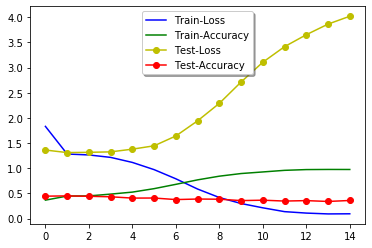

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.plot(list(results.history.values())[2],'y-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'r-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

### Model 5 - CapsNet+Imgage
adapted from keras cifar10 model

In [0]:
from __future__ import print_function
import tensorflow as tf
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator

In [0]:
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x
# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)

In [0]:
class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3)) #重新排序维度

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
#             o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            o = self.activation(tf.keras.backend.batch_dot(c, hat_inputs, [2, 2]))
#             #新版的Keras batch_dot 的结果和原作者expected shape不同
            if i < self.routings - 1:
                b = tf.keras.backend.batch_dot(o, hat_inputs, [2, 3])
#                 b = K.batch_dot(o, hat_inputs, [2, 3])
        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [0]:
batch_size = 64
epochs = 10
num_class = 5

# A common Conv2D model
input_image = Input(shape=(None, None, 3))
x = Conv2D(64, (3, 3), activation='relu')(input_image)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)


x = Reshape((-1, 128))(x)
capsule = Capsule(num_class, 16, 3, True)(x)
output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
model = Model(inputs=input_image, outputs=output)

# we use a margin loss
model.compile(loss=margin_loss, optimizer='adam', metrics=['accuracy'])
# model.summary()

In [0]:
results = model.fit(
        X,
        Y,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
#         validation_data=(testX, testY),
        shuffle=True,
#         class_weight=class_weights
)

Train on 5579 samples, validate on 1395 samples
Epoch 1/10
5579/5579 [==============================] - 9s 2ms/step - loss: 0.3370 - acc: 0.4472 - val_loss: 0.3372 - val_acc: 0.4459
Epoch 2/10
1408/5579 [======>.......................] - ETA: 6s - loss: 0.3395 - acc: 0.4403

KeyboardInterrupt: ignored

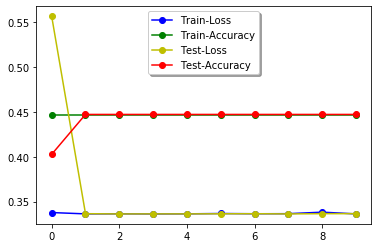

In [0]:
plt.plot(list(results.history.values())[0],'b-o',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g-o',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.plot(list(results.history.values())[2],'y-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'r-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

CapsNet + Image + Data Augmentation

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(trainX)

    # Fit the model on the batches generated by datagen.flow().
results = model.fit_generator(
        datagen.flow(trainX, trainY, batch_size=batch_size),
        epochs=epochs,
        validation_data=(testX, testY),
        workers=4)


Epoch 1/10
88/88 [==============================] - 14s 163ms/step - loss: 0.4954 - acc: 0.4118 - val_loss: 0.3396 - val_acc: 0.4466
Epoch 2/10
88/88 [==============================] - 11s 121ms/step - loss: 0.3374 - acc: 0.4471 - val_loss: 0.3365 - val_acc: 0.4466
Epoch 3/10
88/88 [==============================] - 11s 125ms/step - loss: 0.3372 - acc: 0.4488 - val_loss: 0.3370 - val_acc: 0.4466
Epoch 4/10
36/88 [===========>..................] - ETA: 5s - loss: 0.3372 - acc: 0.4475

In [0]:
plt.plot(list(results.history.values())[0],'b-o',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g-o',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.plot(list(results.history.values())[2],'y-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'r-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

## Image+Text


In [0]:
#text data
padded_train.shape

(6974, 192)

In [0]:
#image data
X.shape, Y.shape

((6974, 128, 128, 3), (6974, 5))

In [0]:
# use classes weights to handle data imbalance
trainYcate = [np.argmax(i) for i in Y]
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(trainYcate),
                                                 trainYcate)
class_weights

array([1.35417476, 0.44748155, 0.63457689, 2.91189979, 9.29866667])

#### Model 4 - Concat CNN+LSTM

In [0]:
a = input_text = Input(shape = max_length)
a = Embedding(vocab_size, 100)(a)
a = CuDNNLSTM(128, return_sequences=True)(a)
a = CuDNNLSTM(128)(a)
a = Flatten()(a)
a = Dense(128, activation='relu')(a)

# output = Dense(5, activation='softmax')(a)
# Model_text_clr = Model(input_text,output)
# Model_text_clr.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy,optimizer = 'adam',metrics = ['accuracy'])
# Model_text_clr.summary()

In [0]:
b = input_img = Input(shape = (width, height, channels))
b = Conv2D(32, (3, 3), activation='relu')(b)
b = MaxPooling2D((2,2))(b)
b = Conv2D(64, (3, 3), activation='relu')(b)
b = MaxPooling2D((2,2))(b)
b = Flatten()(b)
b = Dense(128, activation='relu')(b)
# output = Dense(5, activation='softmax')(b)
# Model_img_clr = Model(input_img,output)
# Model_img_clr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [0]:
combine = Concatenate(axis=-1,)([a,b])
# combine = Dense(64, activation='relu')(combine)
# combine = Dropout(0.2)(combine)
# combine = Dense(32, activation='relu')(combine)
# combine = Dropout(0.2)(combine)
output = Dense(5, activation='softmax')(combine)
Model_text_img_clr = Model([input_text,input_img],output)
Model_text_img_clr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
Model_text_img_clr.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 192)]        0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 126, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 192, 100)     1333500     input_1[0][0]                    
______________________________________________________________________________________________

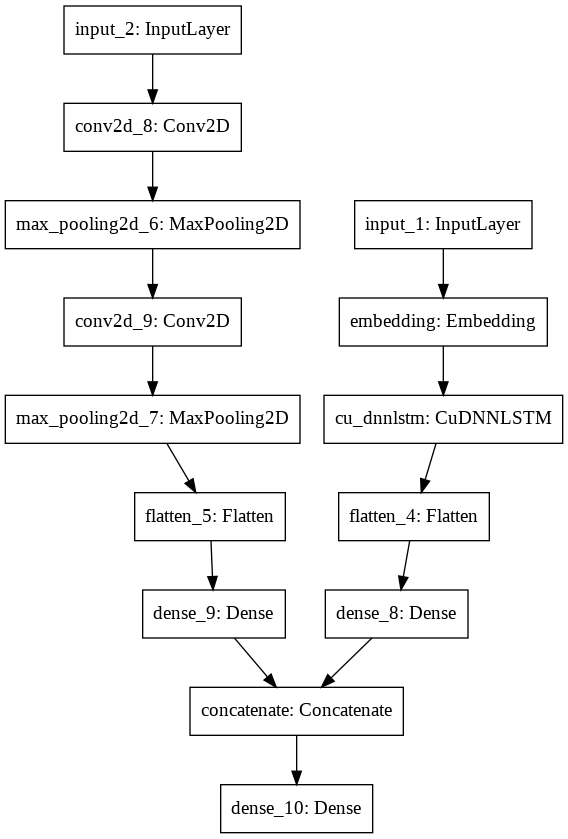

In [0]:
plot_model(Model_text_img_clr, to_file='model.png')

In [0]:
results = Model_text_img_clr.fit([padded_train,X], Y,
         epochs=5,
         batch_size=64,
         shuffle=True,
        validation_split=0.2,
         class_weight=class_weights          
)

Train on 5579 samples, validate on 1395 samples
Epoch 1/5
5579/5579 [==============================] - 26s 5ms/sample - loss: 1.5301 - acc: 0.4114 - val_loss: 1.2765 - val_acc: 0.4459
Epoch 2/5
5579/5579 [==============================] - 8s 1ms/sample - loss: 1.2754 - acc: 0.4476 - val_loss: 1.2736 - val_acc: 0.4459
Epoch 3/5
5579/5579 [==============================] - 8s 1ms/sample - loss: 1.2541 - acc: 0.4547 - val_loss: 1.2894 - val_acc: 0.4487
Epoch 4/5
5579/5579 [==============================] - 8s 1ms/sample - loss: 1.1808 - acc: 0.4938 - val_loss: 1.3328 - val_acc: 0.4315
Epoch 5/5
5579/5579 [==============================] - 8s 1ms/sample - loss: 1.0229 - acc: 0.5757 - val_loss: 1.4944 - val_acc: 0.4007


In [0]:
# Model_text_img_clr.evaluate()

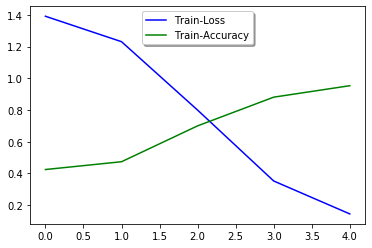

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)

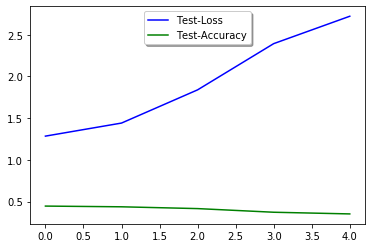

In [0]:
plt.plot(list(results.history.values())[2],'b',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

### Model 6 - CapsNet+Text+Img

In [0]:
batch_size = 64
epochs = 10
num_class = 5

# A common Conv2D model
input_image = Input(shape=(None, None, 3))
x = Conv2D(64, (3, 3), activation='relu')(input_image)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Reshape((-1, 128))(x)
capsule = Capsule(num_class, 16, 3, True)(x)

output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
model = Model(inputs=input_image, outputs=output)

# we use a margin loss
model.compile(loss=margin_loss, optimizer='adam', metrics=['accuracy'])
# model.summary()

### Task-B

#### Single classification

In [0]:
data.head(1)

,Image_name,Image_URL,OCR_extracted_text,corrected_text,Humour,Sarcasm,offensive,Motivational,Overall_Sentiment,img_width,img_height
0,10_year_10-year-challenge_1547788782.jpeg,https://spiderimg.amarujala.com/assets/images/...,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive,749,506


In [0]:
Y_s = data['Sarcasm']
# Y_s = data['Humour']
# Y_s = data['offensive']
# Y_s = data['Motivational']

num_class = 4
Y_s = Y_s.factorize()[0]
Y_s = pd.Series(Y_s).replace([0,2,3],0)
print(Y_s.value_counts())

# use classes weights to handle data imbalance
from sklearn.utils import class_weight
class_weights_s = class_weight.compute_class_weight('balanced',np.unique(Y_s),Y_s)
Y_s = to_categorical(Y_s)
class_weights_s

1    4515
0    2459
dtype: int64


array([1.41805612, 0.77231451])

In [0]:
model = Sequential()
model.add(Conv2D(32, (2, 2), padding='same', activation='relu', input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

model.add(Conv2D(64, (2, 2), activation='relu',padding='same'))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(2, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()

In [0]:
es = callbacks.EarlyStopping(monitor='acc', mode='max')

# fit model with generator
results = model.fit(X, Y_s,
         epochs=10,
         batch_size=64,
         shuffle=True,
        validation_split=0.2,
         callbacks=[es],
         class_weight=class_weights_s      
         )

Train on 5579 samples, validate on 1395 samples
Epoch 1/10
5579/5579 [==============================] - 4s 768us/sample - loss: 5.2597 - acc: 0.6510 - val_loss: 5.8380 - val_acc: 0.6194
Epoch 2/10
5579/5579 [==============================] - 4s 703us/sample - loss: 5.3147 - acc: 0.6544 - val_loss: 5.8380 - val_acc: 0.6194
Epoch 3/10
5579/5579 [==============================] - 4s 697us/sample - loss: 5.3147 - acc: 0.6544 - val_loss: 5.8380 - val_acc: 0.6194


In [0]:
a = input_text = Input(shape = max_length)
a = Embedding(vocab_size, 100)(a)
a = CuDNNLSTM(128, return_sequences=True)(a)
a = CuDNNLSTM(128)(a)
a = Flatten()(a)
a = Dense(128, activation='relu')(a)

b = input_img = Input(shape = (width, height, channels))
b = Conv2D(32, (3, 3), activation='relu')(b)
b = MaxPooling2D((2,2))(b)
b = Conv2D(64, (3, 3), activation='relu')(b)
b = MaxPooling2D((2,2))(b)
b = Flatten()(b)
b = Dense(128, activation='relu')(b)

combine = Concatenate(axis=-1,)([a,b])
# combine = Dense(64, activation='relu')(combine)
combine = Dropout(0.2)(combine)
# combine = Dense(32, activation='relu')(combine)
# combine = Dropout(0.2)(combine)
output = Dense(2, activation='softmax')(combine)
Model_text_img_clr = Model([input_text,input_img],output)
Model_text_img_clr.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Model_text_img_clr.summary()

In [0]:
np.random.seed(0)
from tensorflow import set_random_seed
set_random_seed(0)

es = callbacks.EarlyStopping(monitor='acc', mode='max')

results = Model_text_img_clr.fit([padded_train,X], Y_s,
         epochs=15,
         batch_size=64,
         shuffle=True,
        validation_split=0.2,
        callbacks=[es],
         class_weight=class_weights_s      
)

Train on 5579 samples, validate on 1395 samples
Epoch 1/15
5579/5579 [==============================] - 7s 1ms/sample - loss: 0.9271 - acc: 0.7552 - val_loss: 0.5244 - val_acc: 0.7892
Epoch 2/15
5579/5579 [==============================] - 6s 1ms/sample - loss: 0.5314 - acc: 0.7770 - val_loss: 0.5213 - val_acc: 0.7892
Epoch 3/15
5579/5579 [==============================] - 6s 1ms/sample - loss: 0.5178 - acc: 0.7772 - val_loss: 0.5222 - val_acc: 0.7892
Epoch 4/15
5579/5579 [==============================] - 6s 1ms/sample - loss: 0.4797 - acc: 0.7851 - val_loss: 0.5375 - val_acc: 0.7821
Epoch 5/15
5579/5579 [==============================] - 6s 1ms/sample - loss: 0.4026 - acc: 0.8199 - val_loss: 0.6013 - val_acc: 0.7427
Epoch 6/15
5579/5579 [==============================] - 6s 1ms/sample - loss: 0.3087 - acc: 0.8686 - val_loss: 0.7477 - val_acc: 0.7484
Epoch 7/15
5579/5579 [==============================] - 6s 1ms/sample - loss: 0.1966 - acc: 0.9211 - val_loss: 0.9457 - val_acc: 0.7183


#### Multi-label classification

In [0]:
data['s'] = list(pd.Series(data['Sarcasm'].factorize()[0]).replace([0,2,3],'1').replace(1,0).replace('1',1)) #['general', 'not_sarcastic', 'twisted_meaning', 'very_twisted']
data['h'] = list(pd.Series(data['Humour'].factorize()[0]).replace([1,2,3],1)) #['not_funny', 'very_funny', 'hilarious', 'funny']
data['o'] = list(pd.Series(data['offensive'].factorize()[0]).replace([1,2,3],1)) #['not_offensive', 'very_offensive', 'slight', 'hateful_offensive']


In [0]:
s_h_o = []
for i in data.index:
  concat =  ''.join([str(data['s'][i]),str(data['h'][i]),str(data['o'][i])])
#   concat =  [data['s'][i],data['h'][i],data['o'][i]]
  s_h_o.append(concat)
data['s_h_o']=s_h_o

In [0]:
Y_sho = data['s_h_o'].factorize()[0]
# use classes weights to handle data imbalance
from sklearn.utils import class_weight
class_weights_s = class_weight.compute_class_weight('balanced',np.unique(Y_sho),Y_sho)
Y_sho = to_categorical(Y_sho)
class_weights_s

array([2.91555184, 1.30893393, 0.27310464, 1.70931373, 0.70931652,
       3.61721992, 1.21752793, 7.20454545])

In [0]:
np.random.seed(0)
from tensorflow import set_random_seed
set_random_seed(0)

a = input_text = Input(shape = max_length)
a = Embedding(vocab_size, 100)(a)
a = CuDNNLSTM(128, return_sequences=True)(a)
a = CuDNNLSTM(128)(a)
a = Flatten()(a)
a = Dense(128, activation='relu')(a)

b = input_img = Input(shape = (width, height, channels))
b = Conv2D(32, (3, 3), activation='relu')(b)
b = MaxPooling2D((2,2))(b)
b = Conv2D(64, (3, 3), activation='relu')(b)
b = MaxPooling2D((2,2))(b)
b = Flatten()(b)
b = Dense(128, activation='relu')(b)

combine = Concatenate(axis=-1,)([a,b])
# combine = Dense(64, activation='relu')(combine)
combine = Dropout(0.2)(combine)
# combine = Dense(32, activation='relu')(combine)
# combine = Dropout(0.2)(combine)
output = Dense(8, activation='softmax')(combine)
Model_text_img_clr = Model([input_text,input_img],output)
Model_text_img_clr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Model_text_img_clr.summary()

es = callbacks.EarlyStopping(monitor='acc', mode='max')

results = Model_text_img_clr.fit([padded_train,X], Y_sho,
         epochs=15,
         batch_size=64,
         shuffle=True,
        validation_split=0.2,
        callbacks=[es],
         class_weight=class_weights_s      
)

Train on 5579 samples, validate on 1395 samples
Epoch 1/15
5579/5579 [==============================] - 22s 4ms/sample - loss: 1.7832 - acc: 0.4384 - val_loss: 1.6141 - val_acc: 0.4695
Epoch 2/15
5579/5579 [==============================] - 5s 924us/sample - loss: 1.6418 - acc: 0.4547 - val_loss: 1.6293 - val_acc: 0.4695
Epoch 3/15
5579/5579 [==============================] - 5s 937us/sample - loss: 1.5889 - acc: 0.4598 - val_loss: 1.6394 - val_acc: 0.4652
Epoch 4/15
5579/5579 [==============================] - 5s 933us/sample - loss: 1.3861 - acc: 0.5117 - val_loss: 1.7841 - val_acc: 0.4301
Epoch 5/15
5579/5579 [==============================] - 5s 930us/sample - loss: 1.0021 - acc: 0.6426 - val_loss: 2.1356 - val_acc: 0.3441
Epoch 6/15
5579/5579 [==============================] - 5s 938us/sample - loss: 0.6048 - acc: 0.7915 - val_loss: 2.6845 - val_acc: 0.3591
Epoch 7/15
5579/5579 [==============================] - 5s 933us/sample - loss: 0.3485 - acc: 0.8939 - val_loss: 3.3867 - val

# Manual Test

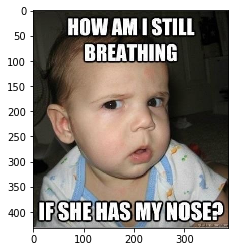

In [0]:
test_img = cv2.cvtColor(cv2.imread(PATH_IMG+data['Image_name'][1]), cv2.COLOR_BGR2RGB)
plt.imshow(test_img)

In [0]:
data[:5]

,Image_name,OCR_extracted_text,Overall_Sentiment
0,10_year_10-year-challenge_1547788782.jpeg,The best of #10 YearChallenge! Completed in le...,very_positive
1,10_year_10yearchallenge-5c75f8b946e0fb0001edc7...,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
2,10_year_10-year-challenge-sweet-dee-edition-40...,10 Year Challenge - Sweet Dee Edition,positive
3,10_year_10-year-challenge-with-no-filter-47-hi...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral
4,10_year_10-years-challenge-about-humanity_o_72...,"1998: ""Don't get in car with strangers"" 2008: ...",negative


In [0]:
#prediction
temp = model.predict(X[800:813].reshape(-1,50,73,3))
temp_pre = [np.argmax(i) for i in temp]
temp_pre

[3, 2, 1, 1, 2, 1, 2, 2, 3, 2, 0, 1, 2]

In [0]:
#Ground Truth
temp = Y[800:813]
temp_truth = [np.argmax(i) for i in temp]
temp_truth

[2, 0, 2, 4, 2, 1, 0, 1, 3, 4, 0, 1, 1]

In [0]:
accuracy_score(temp_pre, temp_truth)

0.38461538461538464

In [0]:
model.evaluate(X[800:813],Y[800:813])

13/13 [==============================] - 0s 573us/sample - loss: 1.4527 - acc: 0.7538


[1.4527454376220703, 0.75384617]

In [0]:
12/13

0.9230769230769231